# DS105 Superstars Final Project
## Contributors:
Shuyu Cao
Sijia He
Simon
Yinyue Wang

## Set Up

In [4]:
import json
import numpy as np
import pandas as pd
from plotnine import *
from IPython.display import HTML, Image
from bs4 import BeautifulSoup
import json
import os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
from ssl import Options
from selenium.webdriver.chrome.service import Service
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from xgboost import XGBClassifier
import pickle
import time
import wordcloud
import seaborn
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

## Data Collection and Data Cleaning

## Data Visualisation

## Data Modeling

#### Model 1: XGB Classification

In [5]:
steam_data = pd.read_csv('steam_clean.csv')
steam_data_prepare = steam_data.copy()

### Get the median of range (owner)

In [6]:
def getMedian(x):
    '''
    Get median of range 
    '''
    x_list = [ float(x) for x in x.split("-")]
    x_median = np.median(x_list)
    return x_median

In [7]:
steam_data_prepare["owners_median"] = steam_data["owners"].apply(lambda x: getMedian(x))
steam_data_prepare["owners_median"] 

0        15000000.0
1         7500000.0
2         1500000.0
3          150000.0
4         3500000.0
            ...    
55782       10000.0
55783       10000.0
55784       10000.0
55785       10000.0
55786       10000.0
Name: owners_median, Length: 55787, dtype: float64

In [8]:
# get the information of owners

df_owner_infor = { df_tmp[0]: len(df_tmp[1]) for df_tmp in steam_data_prepare.groupby("owners")}
df_owner_infor = { x:y for x,y in sorted(df_owner_infor.items(), key = lambda x: getMedian(x[0]))}

Text(0.5, 1.0, 'Distribution of Owner Number')

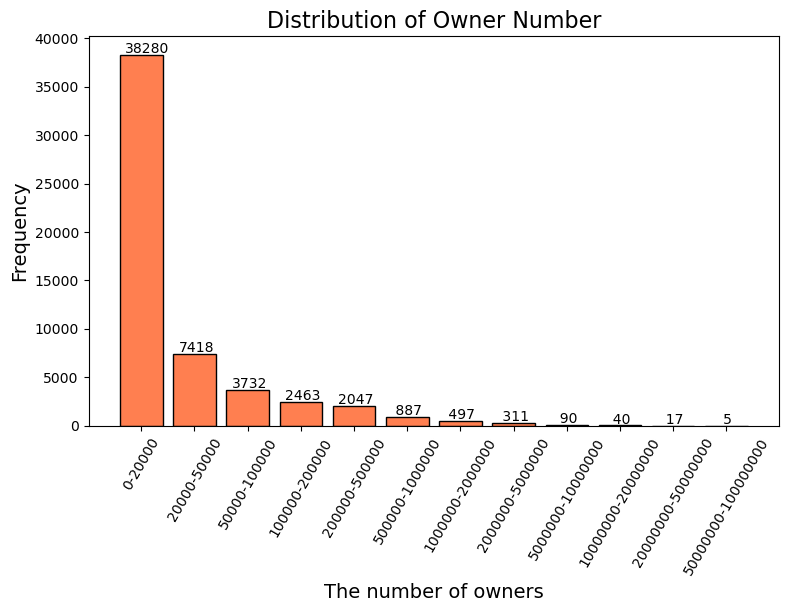

In [9]:
# Draw a distribution of owners

fig = plt.figure(figsize=[8,6])
ax = plt.gca()
plt.bar(df_owner_infor.keys(), df_owner_infor.values(), edgecolor="black", color="coral")
for idx, key in enumerate(df_owner_infor.keys()):
    ax.annotate("{:>4s}".format(str(df_owner_infor[key])), (idx-0.3, df_owner_infor[key] + 200), fontsize=10)
plt.xticks(rotation="60", fontsize=10)
plt.tight_layout(pad=2)
plt.xlabel("The number of owners", size=14)
plt.ylabel("Frequency", size=14)
plt.title("Distribution of Owner Number", size=16)

In [10]:
# get the average of median of owners with 2 digits

owner_average = round(steam_data_prepare["owners_median"].mean(), 2)
owner_average 

121040.39

In [11]:
for idx in steam_data.loc[steam_data["owners"].isin(["100000000-200000000", "50000000-100000000", "20000000-50000000", "10000000-20000000"])].index:
    steam_data.iloc[idx, 18] = owner_average

In [12]:
# change number into classes
warnings.filterwarnings('ignore')
Y = steam_data_prepare[["owners_median"]]
ec = LabelEncoder()
steam_data_prepare["target"] = ec.fit_transform(Y)

In [13]:
print("After conversion, there are {} classes, which are corresponding to different owner number ranges." .format(len(set(steam_data_prepare["target"]))))

After conversion, there are 12 classes, which are corresponding to different owner number ranges.


In [14]:
# create train and test data

train, test = train_test_split(steam_data_prepare, test_size=0.2, random_state=42)

In [15]:
# create train and validation data

train, val = train_test_split(train, test_size=0.2, random_state=42)

In [16]:
train.shape

(35703, 22)

In [17]:
test.shape

(11158, 22)

In [18]:
val.shape

(8926, 22)

In [19]:
steam_data_prepare.columns

Index(['appid', 'name', 'release_date', 'owners', 'ccu', 'price', 'languages',
       'english', 'developer', 'publisher', 'platforms', 'required_age',
       'categories', 'genres', 'steamspy_tags', 'achievements',
       'positive_ratings', 'negative_ratings', 'average_playtime',
       'median_playtime', 'owners_median', 'target'],
      dtype='object')

In [24]:
label_encoder = LabelEncoder()


In [28]:
## XGBoost
X = steam_data_prepare[['positive_ratings', 'achievements', 'price']]
y = steam_data_prepare['owners_median']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# convert the dataset into an optimized data structure which the Model can ingest
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

# initialize XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)

# fit the model to the training data
xg_reg.fit(X_train, y_train)

# predicting the test set results
y_pred = xg_reg.predict(X_test)


[16:12:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [32]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))


RMSE: 942366.558249


## Distribution of catigories 